cuda
Training data : 
 noisy_imgs_1 :  torch.Size([50000, 3, 32, 32]) 
 noisy_imgs_2 :  torch.Size([50000, 3, 32, 32])
Data reduced : 
 noisy_imgs_1_reduced :  torch.Size([50000, 3, 32, 32]) 
 noisy_imgs_2_reduced :  torch.Size([50000, 3, 32, 32])
Type :  torch.uint8
epoch :  1
The epoch took 53.04860758781433s to complete

epoch :  2
The epoch took 52.36190152168274s to complete

epoch :  3
The epoch took 52.31913733482361s to complete

epoch :  4
The epoch took 52.26980209350586s to complete

epoch :  5
The epoch took 52.29660439491272s to complete

epoch :  6
The epoch took 52.354100704193115s to complete

epoch :  7
The epoch took 52.30505061149597s to complete

epoch :  8
The epoch took 52.16306257247925s to complete

epoch :  9
The epoch took 52.36774158477783s to complete

epoch :  10
The epoch took 52.31372928619385s to complete



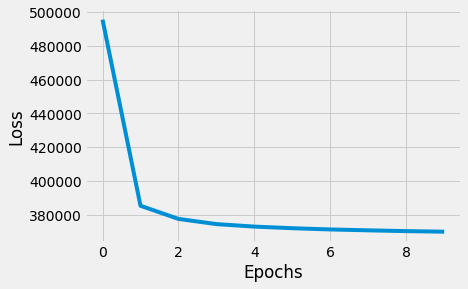

Finished training after 524.0307860374451.




------------------------------------------------
validation


Test data : 
 noisy_imgs :  torch.Size([1000, 3, 32, 32]) 
 clean_imgs :  torch.Size([1000, 3, 32, 32])
Data reduced : 
 noisy_imgs_1_reduced :  torch.Size([1000, 3, 32, 32]) 
 noisy_imgs_2_reduced :  torch.Size([1000, 3, 32, 32])
Type :  torch.uint8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 32, 32])


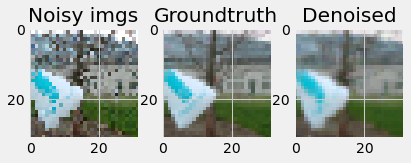

PSNR mean :  25.33062171936035  dB


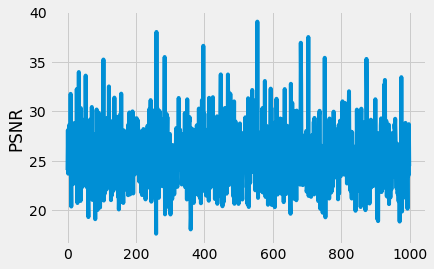

SSIM mean :  18.872650146484375


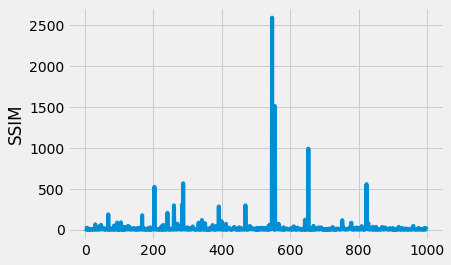

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 27 15:43:57 2022

@author: louis
"""
"file for colab"
import torch 
# import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def psnr(denoised, ground_truth):
    # Peak Signal to Noise Ratio: denoised and ground ̇truth have range [0, 1]
    mse = torch.mean((denoised - ground_truth) ** 2)
    return -10 * torch.log10(mse + 10**-8)

def ssim(denoised, ground_truth):
    mu_x = torch.mean(denoised)
    mu_y = torch.mean(ground_truth)
    var_x = torch.var(denoised.view(-1))
    var_y = torch.var(ground_truth.view(-1))
    cov_xy = np.correlate(denoised.view(-1).numpy(), ground_truth.view(-1).numpy())
    c1 = (0.01 * 255) ** 2
    c2 = (0.03 * 255) ** 2
    c3 = c2 / 2
    luminance = (2 * mu_x * mu_y + c1) / (mu_x ** 2 + mu_y ** 2 + c1)
    contrast = (2 * var_x * var_y + c2) / (var_x ** 2 + var_y ** 2 + c2)
    structure = (cov_xy + c3) / (var_x * var_y + c3)
    return luminance * contrast * structure

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, SIZE, train = True):
        'Initialization'
        if train: 
            x, y = torch.load("drive/MyDrive/Colab_Notebooks/DeepL_miniProj/train_data.pkl") #drive/MyDrive/Colab_Notebooks/DeepL_miniProj
            print("Training data : \n noisy_imgs_1 : ", x.shape, "\n noisy_imgs_2 : ", y.shape)
            if SIZE > 50000:
                print("You entered a size too big, using size = 50000")
                SIZE = 50000
        else : 
            x, y = torch.load("drive/MyDrive/Colab_Notebooks/DeepL_miniProj/val_data.pkl")
            print("Test data : \n noisy_imgs : ", x.shape, "\n clean_imgs : ", y.shape)
            if SIZE > 50000:
                print("You entered a size too big, using size = 1000")
                SIZE = 1000
        x, y = x[:SIZE], y[:SIZE]
        print("Data reduced : \n noisy_imgs_1_reduced : ", x.shape, "\n noisy_imgs_2_reduced : ", y.shape)
        print("Type : ", x.dtype)
        self.x = x.float()
        self.y = y.float()

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        # get label
        X = self.x[index]
        Y = self.y[index]
        return X, Y
    
class AE(torch.nn.Module):
    def __init__(self):
        # channel per channel operation
        pad_mode = 'replicate'
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.l_relu = nn.LeakyReLU(negative_slope = 0.01) #nn.PReLU(init = 0.05) #
        self.upsample = nn.Upsample(scale_factor = (2, 2))
        self.batchnorm16 = nn.BatchNorm2d(num_features = 16)
        self.batchnorm24 = nn.BatchNorm2d(num_features = 24)
        self.batchnorm32 = nn.BatchNorm2d(num_features = 32)
        self.batchnorm1 = nn.BatchNorm2d(num_features = 1)
        self.conv1_1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1, padding_mode = pad_mode) # 32 x 32 
        self.conv1_2 = nn.Conv2d(in_channels = 16, out_channels = 24, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.conv1_3 = nn.Conv2d(in_channels = 24, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.conv1_4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.conv1_5 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        
        self.deconv1_1 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.deconv1_2 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.deconv1_3 = nn.Conv2d(in_channels = 56, out_channels = 24, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.deconv1_4 = nn.Conv2d(in_channels = 40, out_channels = 16, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.deconv1_5 = nn.Conv2d(in_channels = 17, out_channels = 1, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        
        self.conv2_1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1, padding_mode = pad_mode) # 32 x 32 
        self.conv2_2 = nn.Conv2d(in_channels = 16, out_channels = 24, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.conv2_3 = nn.Conv2d(in_channels = 24, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.conv2_4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.conv2_5 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        
        self.deconv2_1 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.deconv2_2 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.deconv2_3 = nn.Conv2d(in_channels = 56, out_channels = 24, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.deconv2_4 = nn.Conv2d(in_channels = 40, out_channels = 16, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.deconv2_5 = nn.Conv2d(in_channels = 17, out_channels = 1, kernel_size = 3, padding = 1, padding_mode = pad_mode)

        self.conv3_1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1, padding_mode = pad_mode) # 32 x 32 
        self.conv3_2 = nn.Conv2d(in_channels = 16, out_channels = 24, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.conv3_3 = nn.Conv2d(in_channels = 24, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.conv3_4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.conv3_5 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        
        self.deconv3_1 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.deconv3_2 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.deconv3_3 = nn.Conv2d(in_channels = 56, out_channels = 24, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.deconv3_4 = nn.Conv2d(in_channels = 40, out_channels = 16, kernel_size = 3, padding = 1, padding_mode = pad_mode) 
        self.deconv3_5 = nn.Conv2d(in_channels = 17, out_channels = 1, kernel_size = 3, padding = 1, padding_mode = pad_mode)
        
  
    def forward(self, x):
        # Extract the 3 channels
        x1 = x[:, 0, :, :].reshape((x.shape[0], 1, x.shape[2], -1))
        x2 = x[:, 1, :, :].reshape((x.shape[0], 1, x.shape[2], -1))
        x3 = x[:, 2, :, :].reshape((x.shape[0], 1, x.shape[2], -1))
        #print(x1.shape, x2.shape, x3.shape)

        # Encode separately each channel
        # First channel
        x1_1 = self.l_relu(self.conv1_1(x1))
        x1_1 = self.l_relu(self.pool(x1_1))

        x1_2 = self.l_relu(self.conv1_2(x1_1))
        x1_2 = self.l_relu(self.pool(x1_2))

        x1_3 = self.l_relu(self.conv1_3(x1_2))
        x1_3 = self.l_relu(self.pool(x1_3))

        x1_4 = self.l_relu(self.conv1_4(x1_3))
        x1_4 = self.l_relu(self.pool(x1_4))

        x1_5 = self.l_relu(self.conv1_5(x1_4))
        #print(x5.shape)

        # Second channel
        x2_1 = self.l_relu(self.conv2_1(x2))
        x2_1 = self.l_relu(self.pool(x2_1))

        x2_2 = self.l_relu(self.conv2_2(x2_1))
        x2_2 = self.l_relu(self.pool(x2_2))

        x2_3 = self.l_relu(self.conv2_3(x2_2))
        x2_3 = self.l_relu(self.pool(x2_3))

        x2_4 = self.l_relu(self.conv2_4(x2_3))
        x2_4 = self.l_relu(self.pool(x2_4))

        x2_5 = self.l_relu(self.conv2_5(x2_4))

        # Third channel
        x3_1 = self.l_relu(self.conv3_1(x3))
        x3_1 = self.l_relu(self.pool(x3_1))

        x3_2 = self.l_relu(self.conv3_2(x3_1))
        x3_2 = self.l_relu(self.pool(x3_2))

        x3_3 = self.l_relu(self.conv3_3(x3_2))
        x3_3 = self.l_relu(self.pool(x3_3))

        x3_4 = self.l_relu(self.conv3_4(x3_3))
        x3_4 = self.l_relu(self.pool(x3_4))

        x3_5 = self.l_relu(self.conv3_5(x3_4))

        # decode separetely each channel
        # First channel
        y1_1 = torch.cat((x1_5, x1_4), dim = 1)
        y1_1 = self.l_relu(self.upsample(y1_1))
        y1_1 = self.l_relu(self.deconv1_1(y1_1))
        #print(y1.shape)
        y1_2 = torch.cat((y1_1, x1_3), dim = 1)
        y1_2 = self.l_relu(self.upsample(y1_2))
        y1_2 = self.l_relu(self.deconv1_2(y1_2))
        #print(y2.shape)
        y1_3 = torch.cat((y1_2, x1_2), dim = 1)
        y1_3 = self.l_relu(self.upsample(y1_3))
        y1_3 = self.l_relu(self.deconv1_3(y1_3))
        #print(y3.shape)
        y1_4 = torch.cat((y1_3, x1_1), dim = 1)
        y1_4 = self.l_relu(self.upsample(y1_4))
        y1_4 = self.l_relu(self.deconv1_4(y1_4))
        #print(y4.shape)
        y1_5 = torch.cat((y1_4, x1), dim = 1)
        #print(y5.shape)
        y1_5 = self.l_relu(self.deconv1_5(y1_5))
        torch.clamp(y1_5, min = 0, max = 255)

        # Second channel
        y2_1 = torch.cat((x2_5, x2_4), dim = 1)
        y2_1 = self.l_relu(self.upsample(y2_1))
        y2_1 = self.l_relu(self.deconv2_1(y2_1))
        #print(y1.shape)
        y2_2 = torch.cat((y2_1, x2_3), dim = 1)
        y2_2 = self.l_relu(self.upsample(y2_2))
        y2_2 = self.l_relu(self.deconv2_2(y2_2))
        #print(y2.shape)
        y2_3 = torch.cat((y2_2, x2_2), dim = 1)
        y2_3 = self.l_relu(self.upsample(y2_3))
        y2_3 = self.l_relu(self.deconv2_3(y2_3))
        #print(y3.shape)
        y2_4 = torch.cat((y2_3, x2_1), dim = 1)
        y2_4 = self.l_relu(self.upsample(y2_4))
        y2_4 = self.l_relu(self.deconv2_4(y2_4))
        #print(y4.shape)
        y2_5 = torch.cat((y2_4, x2), dim = 1)
        #print(y5.shape)
        y2_5 = self.l_relu(self.deconv2_5(y2_5))
        torch.clamp(y2_5, min = 0, max = 255)

        # Thrid channel
        y3_1 = torch.cat((x3_5, x3_4), dim = 1)
        y3_1 = self.l_relu(self.upsample(y3_1))
        y3_1 = self.l_relu(self.deconv3_1(y3_1))
        #print(y1.shape)
        y3_2 = torch.cat((y3_1, x3_3), dim = 1)
        y3_2 = self.l_relu(self.upsample(y3_2))
        y3_2 = self.l_relu(self.deconv3_2(y3_2))
        #print(y2.shape)
        y3_3 = torch.cat((y3_2, x3_2), dim = 1)
        y3_3 = self.l_relu(self.upsample(y3_3))
        y3_3 = self.l_relu(self.deconv3_3(y3_3))
        #print(y3.shape)
        y3_4 = torch.cat((y3_3, x3_1), dim = 1)
        y3_4 = self.l_relu(self.upsample(y3_4))
        y3_4 = self.l_relu(self.deconv3_4(y3_4))
        #print(y4.shape)
        y3_5 = torch.cat((y3_4, x3), dim = 1)
        #print(y5.shape)
        y3_5 = self.l_relu(self.deconv3_5(y3_5))
        torch.clamp(y3_5, min = 0, max = 255)

        y = torch.cat((y1_5, y2_5, y3_5), dim = 1)
        return y

def plot_3imgs(denoised, ground_truth, noisy_imgs, add_title = ''): #values of the images are in between [0, 255].
    plt.subplot(1, 3, 1)
    print(noisy_imgs.shape)
    plt.imshow(torch.squeeze(noisy_imgs).permute(1, 2, 0).int()) #int since the data has been changed to float for the NN.
    plt.title("Noisy imgs")
    plt.subplot(1, 3, 2)
    plt.imshow(torch.squeeze(ground_truth).permute(1, 2, 0).int())
    plt.title("Groundtruth")
    plt.subplot(1,3,3)
    plt.imshow(torch.squeeze(denoised).permute(1, 2, 0).int())
    plt.title("Denoised")
    plt.savefig('drive/MyDrive/Colab_Notebooks/DeepL_miniProj/ae-small11/' + Losstype + add_title + '.png', dpi = 300)
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import torch
from datetime import datetime
import time


"""
noisy_imgs_1, noisy_imgs_2 = torch.load("train_data.pkl")
print("Training data : \n noisiy_imgs_1 : ", noisy_imgs_1.shape, "\n noisy_imgs_2 : ", noisy_imgs_2.shape)
noisy_imgs, clean_imgs = torch.load("val_data.pkl")
print("Test data : \n noisiy_imgs : ", noisy_imgs.shape, "\n clean_imgs : ", clean_imgs.shape)
noisy_imgs_1_reduced, noisy_imgs_2_reduced = noisy_imgs_1[:SIZE], noisy_imgs_2[:SIZE]
print("Training data reduced : \n noisiy_imgs_1_reduced : ", noisy_imgs_1_reduced.shape, "\n noisy_imgs_2_reduced : ", noisy_imgs_2_reduced.shape)
all_noisy_imgs = torch.cat((noisy_imgs_1_reduced, noisy_imgs_2_reduced), dim = 0)
print("Concatenated training data (reduced) : \n all_noisy_imgs : ", all_noisy_imgs.shape)
"""

SIZE = 50000
BATCH_SIZE = 128
train_set = Dataset(SIZE)

"""N = 20
plt.figure()
for i in range(N):
    plt.subplot(2, N, 2*i+1)
    plt.imshow(train_set.x[i].permute(1, 2, 0).int())
    plt.subplot(2, N, 2*i+2)
    plt.imshow(train_set.y[i].permute(1, 2, 0).int())
plt.show()"""


# Model Initialization
model = AE().to(device)
  
# Validation using MSE Loss function
loss_function = nn.MSELoss().to(device)
Losstype = "L1"
Losstype = "MSE"
  
# Using an Adam Optimizer with lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3, betas=(0.9, 0.99))

# DataLoader is used to load the dataset 
# for training
loader_1 = torch.utils.data.DataLoader(dataset = train_set,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)


#OPTIMIZATION
epochs = 10
outputs = []
losses = []
start_ = time.time()
for epoch in range(epochs):
    print("epoch : ", epoch + 1)
    start = time.time()
    Loss = 0
    for noisy_imgs_1, noisy_imgs_2 in loader_1:
        #print(noisy_imgs_1.shape)
        #print(noisy_imgs_2.shape)

        #noisy_imgs_1 = noisy_imgs_1.reshape(-1, 32 * 32)
        #noisy_imgs_2 = noisy_imgs_2.reshape(-1, 32 * 32)    
        # Output of Autoencoder
        #print("type : ", noisy_imgs_1.dtype)
        noisy_imgs_1, noisy_imgs_2 = noisy_imgs_1.to(device), noisy_imgs_2.to(device)
        reconstructed = model(noisy_imgs_1)
            
        # Calculating the loss function
        loss = loss_function(reconstructed, noisy_imgs_2)
            
        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Storing the losses in a list for plotting
        Loss += loss.detach().cpu().numpy()
    losses.append(Loss)
    print('The epoch took {}s to complete\n'.format(time.time() - start))
    outputs.append((epochs, noisy_imgs_2, reconstructed))
  
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
  
# Plotting the last 100 values
plt.plot(losses)
plt.show()



Time = datetime.now().strftime('%m_%d_%Hh_%Mm_%Ss')

PATH = "drive/MyDrive/Colab_Notebooks/DeepL_miniProj/ae-small11/ae_" + Losstype + Time + ".pth" # so that we don't overwrite files
torch.save(model.state_dict(), PATH)

print('Finished training after {}.'.format(time.time() - start_))
print('\n\n\n')
print('------------------------------------------------')


#model = AE()
#time = '04_27_13h_14m_41s' # to be filled according to the job we want to load
#PATH = "./test1/project1_1_" + time + ".pth"
#model.load_state_dict(torch.load(PATH))


print("validation")
print('\n')
SIZE = 1000
BATCH_SIZE = 1
test_set = Dataset(SIZE, train = False)

"""plt.subplot(2, 1, 1)
plt.imshow(test_set.x[-1].permute(1, 2, 0).int())
plt.subplot(2, 1, 2)
plt.imshow(test_set.y[-1].permute(1, 2, 0).int())
plt.show()"""

loader_2 = torch.utils.data.DataLoader(dataset = test_set,
                                     batch_size = BATCH_SIZE,
                                     shuffle = False)

PSNR = torch.empty(size = (1, SIZE))
SSIM = torch.empty(size = (1, SIZE))
i = 0
for noisy_imgs, ground_truth in loader_2:
    noisy_imgs, ground_truth = noisy_imgs.to(device), ground_truth.to(device)
    denoised = model(noisy_imgs)
    Psnr = psnr(denoised.cpu() / 255, ground_truth.cpu() / 255)
    PSNR[0, i] = Psnr
    SSIM[0, i] = ssim(denoised.detach().cpu(), ground_truth.detach().cpu())
    #if Psnr > 32:
     #   plot_3imgs(denoised, ground_truth, noisy_imgs, add_title = 'good' + str(i))
    #if Psnr < 20:
     #   plot_3imgs(denoised, ground_truth, noisy_imgs, add_title = 'bad' + str(i))
    i += 1

plot_3imgs(denoised.cpu(), ground_truth.cpu(), noisy_imgs.cpu(), add_title = Time)

print("PSNR mean : ", torch.mean(PSNR).item(), " dB")
plt.style.use('fivethirtyeight')
plt.ylabel('PSNR')
plt.plot(PSNR[0,:].detach().numpy())
plt.savefig('drive/MyDrive/Colab_Notebooks/DeepL_miniProj/ae-small11/psnr_' + Losstype + Time + '.png', dpi = 300)
plt.show()

print("SSIM mean : ", torch.mean(SSIM).item())
plt.style.use('fivethirtyeight')
plt.ylabel('SSIM')
plt.plot(SSIM[0,:].detach().numpy())
plt.savefig('drive/MyDrive/Colab_Notebooks/DeepL_miniProj/ae-small11/ssim_' + Losstype + Time + '.png', dpi = 300)
plt.show()